<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/train_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division, absolute_import
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

import numpy.random as npr

import jax.numpy as np
from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, LogSoftmax)

########### JL note: mostly following https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb
########### https://github.com/google/jax/blob/master/examples/resnet50.py

In [0]:
import tensorflow as tf

In [2]:
!pip install --quiet git+https://github.com/liuxx479/Outlier.git

In [3]:
# Second step, import the dataset
%tensorflow_version 2.x
%pylab inline
import tensorflow_datasets as tfds
from outlier.datasets import gaussian_convergence

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
# Third step, profit...
dataset = tfds.load(name="gaussian_convergence", split="train")

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/gaussian_convergence/0.1.0.incompleteEFOORJ/gaussian_convergence-train.tfrecord



Dataset gaussian_convergence downloaded and prepared to /root/tensorflow_datasets/gaussian_convergence/0.1.0. Subsequent calls will reuse this data.


tf.Tensor([0.16992588 0.7251126 ], shape=(2,), dtype=float32)


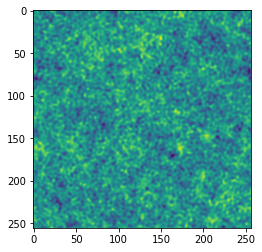

In [5]:
for example in dataset.take(1):  #split the whole set into N mini-batches
  kappa_map, params = example["map"], example["params"]
  imshow(kappa_map)
  print(params)

In [0]:
# ResNet blocks compose other layers

def ConvBlock(kernel_size, filters, strides=(2, 2)):
  ks = kernel_size
  filters1, filters2, filters3 = filters
  Main = stax.serial(
      Conv(filters1, (1, 1), strides), BatchNorm(), Relu,
      Conv(filters2, (ks, ks), padding='SAME'), BatchNorm(), Relu,
      Conv(filters3, (1, 1)), BatchNorm())
  Shortcut = stax.serial(Conv(filters3, (1, 1), strides), BatchNorm())
  return stax.serial(FanOut(2), stax.parallel(Main, Shortcut), FanInSum, Relu)

def IdentityBlock(kernel_size, filters):
  ks = kernel_size
  filters1, filters2 = filters
  def make_main(input_shape):
    # the number of output channels depends on the number of input channels
    return stax.serial(
        Conv(filters1, (1, 1)), BatchNorm(), Relu,
        Conv(filters2, (ks, ks), padding='SAME'), BatchNorm(), Relu,
        Conv(input_shape[3], (1, 1)), BatchNorm())
  Main = stax.shape_dependent(make_main)
  return stax.serial(FanOut(2), stax.parallel(Main, Identity), FanInSum, Relu)

# ResNet architectures compose layers and ResNet blocks
def ResNet50(num_classes):
  ########## JL to do: maybe remove some IdentityBlocks..
  return stax.serial(
      GeneralConv(('HWCN', 'OIHW', 'NHWC'), 64, (7, 7), (2, 2), 'SAME'),
      BatchNorm(), 
      Relu, 
      MaxPool((3, 3), strides=(2, 2)),
      ConvBlock(3, [64, 64, 256], strides=(1, 1)),
      # IdentityBlock(3, [64, 64]),
      IdentityBlock(3, [64, 64]),
      ConvBlock(3, [128, 128, 512]),
      # IdentityBlock(3, [128, 128]),
      # IdentityBlock(3, [128, 128]),
      IdentityBlock(3, [128, 128]),
      ConvBlock(3, [256, 256, 1024]),
      IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      IdentityBlock(3, [256, 256]),
      ConvBlock(3, [512, 512, 2048]),
      # IdentityBlock(3, [512, 512]),
      IdentityBlock(3, [512, 512]),
      AvgPool((7, 7)), 
      Flatten, 
      Dense(num_classes))

In [0]:
from jax import random
rng_key = random.PRNGKey(0)

In [0]:
batch_size = 10 ### number of maps per batch

num_classes = 2
input_shape = (256, 256, 1, batch_size)
step_size = 0.1
num_steps = 16 #1600

init_fun, predict_fun = ResNet50(num_classes)
_, init_params = init_fun(rng_key, input_shape)

def loss(params, batch):
  kappa_map, params_true = batch
  params_pred = predict_fun(params, kappa_map)
  out = np.sum((params_pred - params_true)**2)
  return out

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9)

In [0]:
batches_ = dataset.batch(batch_size)

def synth_batches():
  for ibatch in batches_ :
    yield tf.transpose(tf.expand_dims(ibatch['map'],-1), (1,2,3,0)).numpy(), ibatch['params'].numpy()
    
batches = synth_batches()

In [0]:
########### test shape
# for j in range(5):
#   out = next(batches)
#   print (out[1][0])

In [0]:
@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

opt_state = opt_init(init_params)

for i in range(num_steps):
  opt_state = update(i, opt_state, next(batches))
trained_params = get_params(opt_state)

In [0]:
#print (trained_params)

In [89]:
# def synth_batches2():
#   rng = npr.RandomState(0)
#   while True:
#     images = rng.rand(*input_shape).astype('float32')
#     labels = rng.randint(num_classes, size=(batch_size, 1))
#     onehot_labels = labels == np.arange(num_classes)
#     yield images, onehot_labels
# batches2=synth_batches2()
# out2=next(batches2)

# type(out2[0]), type(out2[1])

####### JL: ok seems like you need to convert to numpy array
# out=next(batches)
# type(out[0].numpy()), type(out[1].numpy())

(numpy.ndarray, numpy.ndarray)

In [104]:
############ check 
j=0
for iparam in trained_params:
  print ('layer:',j, '/ parameter shape:', array(iparam).shape)
  print (iparam)
  j+=1

layer: 0 / parameter shape: (2, 64)
(DeviceArray([[[[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]]],


             [[[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]]],


             [[[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
           